In [1]:
import sys
sys.path.remove('/home/obin/catkin_ws/devel/lib/python2.7/dist-packages')
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import joblib
from skimage.restoration import denoise_tv_chambolle

In [34]:
def overlap(r1,r2):
    hoverlaps = not((r1[0] > r2[1]) or (r1[1] < r2[0]))
    voverlaps = not((r1[3] < r2[2]) or (r1[2] > r2[3]))
    
#     if r1 is r2 :
#         print('same object')
#         return False
    return hoverlaps and voverlaps  

def draw_circle(event,x,y,flags,param):
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDBLCLK:
        #cv2.circle(i,(x,y),10000,(255,0,0),-1)
        mouseX,mouseY = x,y
        #print('point x:{0}, y:{1}'.format(mouseX,mouseY))
def overlap_with_others(obj, object_list):
    overlap_with_others = False
    for other_idx, other_obj in enumerate(object_list) :
        if overlap(other_obj, obj):
            new_obj_min_x = min(other_obj[0],obj[0])
            new_obj_max_x = max(other_obj[1],obj[1])
            new_obj_min_y = min(other_obj[2],obj[2])
            new_obj_max_y = max(other_obj[3],obj[3])
            object_list[other_idx] = [new_obj_min_x, new_obj_max_x, new_obj_min_y, new_obj_max_y]
            overlap_with_others = True
    return overlap_with_others, object_list
    
def extract_objects(img,safe_distance=5):

    for tx in range(256):
        for ty in range(256):
            color = np.array(img[tx,ty,:],dtype=np.int64)
            if (abs(color[0]-color[1]) < 20) and (abs(color[1]-color[2]) < 20): 
                img[tx,ty,:] = [20,20,20]
    depth_image = img
    depth_image=cv2.cvtColor(depth_image,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(depth_image,31,255,0)
    contours, hierachy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    hulls = []
    new_contours = []
    for c in contours :
        if np.array(c).shape[0] <= 1 : continue
        hulls.append(cv2.convexHull(c))
        x = np.array(c).squeeze()[:,0]
        y = np.array(c).squeeze()[:,1]
        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        #out = np.zeros_like(img)
        dx = bottomx - topx
        dy = bottomy - topy
        
        if dx*dy <= 800 : continue
        new_contours.append(c)
    
    #image = cv2.drawContours(img, hulls, -1, 255, 3)
    object_list = []


    for h in hulls :
        x = np.array(h).squeeze()[:,0]
        y = np.array(h).squeeze()[:,1]
        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        #out = np.zeros_like(img)
        dx = bottomx - topx
        dy = bottomy - topy


        out = img[topy:bottomy+1,topx:bottomx+1:]
        mean = np.mean(out,axis=(0,1),dtype=np.int64)

        if dx*dy <= 600 : continue
        if (abs(mean[0] - mean[1]) < 10)and(abs(mean[1] - mean[2]) < 10) : 
            print(abs(mean[0] - mean[1]), abs(mean[1] - mean[2]))
            continue
            
        obj = [topx-safe_distance,bottomx+safe_distance,
               topy-safe_distance,bottomy+safe_distance]
        object_list.append(np.clip(obj,0,255))
#         overlap, new_list = overlap_with_others(obj,object_list)
#         if not overlap :
#             #object_list = new_list
#             object_list.append(np.clip(obj,0,255))
#         else :
#             object_list = new_list
        
        
    return hulls, object_list, new_contours
    

def where_is(pose,objs):
    for idx, obj in enumerate(objs):
        x_ok = obj[0] < pose[0] and obj[1] > pose[0] 
        y_ok = obj[2] < pose[1] and obj[3] > pose[1]
        
        if x_ok and y_ok : return idx
    return -1
            

def move_object(ids,move,object_list,img,black_patch):
    #print('move ', move)
    ob = object_list[ids]
    
    moved_ob = np.array(ob-move,dtype=np.int64)
    if not(all(moved_ob<255) and all(moved_ob>0)) : 
        return False, None, None
    #   print('moved', moved_ob)
    safe_flag = False
    for other_ob in object_list :
        if overlap(moved_ob,other_ob) and any(other_ob != ob) :
            safe_flag=False
            return False, None, None
        safe_flag = True
    object_img = copy.deepcopy(img[ob[2]:ob[3]+1,ob[0]:ob[1]+1,:])

    if safe_flag : 
        dy = ob[3] - ob[2] + 1
        dx = ob[1] - ob[0] + 1
        img[ob[2]:ob[3]+1,ob[0]:ob[1]+1,:] = black_patch[0:dy,0:dx,:]
        img[moved_ob[2]:moved_ob[3]+1, moved_ob[0]:moved_ob[1]+1, :] = object_img
        object_list[ids] = moved_ob
        return True, img, object_list

    return False, None, None



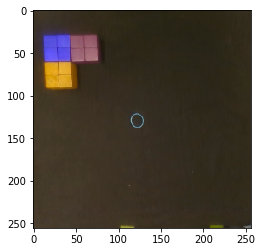

In [3]:
# load test image
pp_path = '/home/obin/t2b_dataset/pickandplace/image'
data_list = np.sort([pp_path+'/'+x for x in os.listdir(os.path.join(pp_path,''))])
img = cv2.imread(data_list[0])
#img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

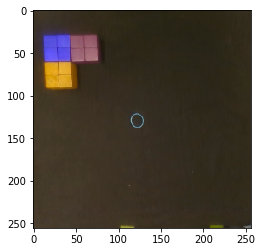

In [4]:
s_img = img
s_hulls,s_objs, _ = extract_objects(s_img)
fig = plt.figure()
s_ax = fig.add_subplot(111)
plt.imshow(s_img)
for s_ob in s_objs :
    randcolor = (np.random.randint(0,100,size=3) + np.array([10,10,150]))/255.0
    rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
                             linewidth=0.00,edgecolor=randcolor,facecolor=randcolor)
    s_ax.add_patch(rect)


plt.show()

25


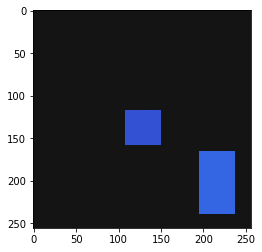

26


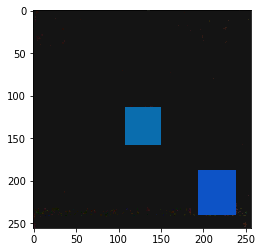

27


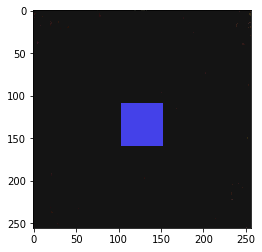

28


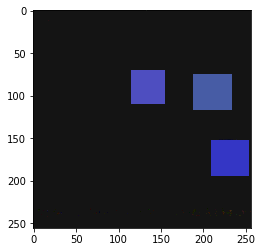

29


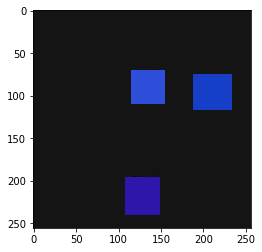

30


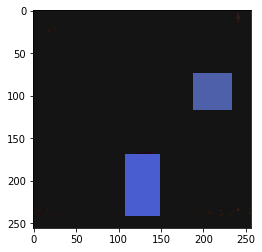

31


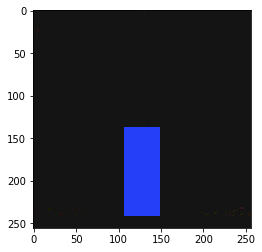

32


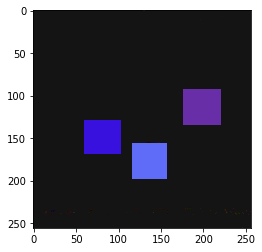

33


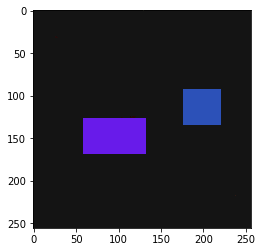

34


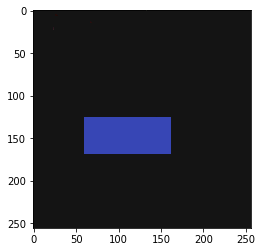

35


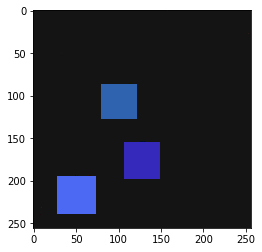

36


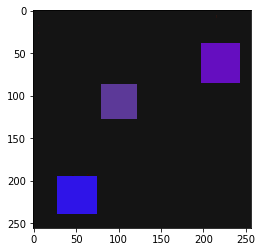

37


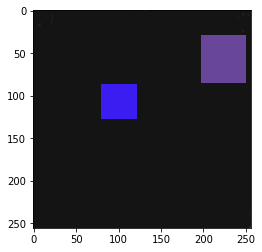

38


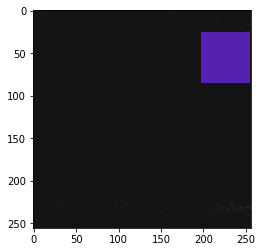

39


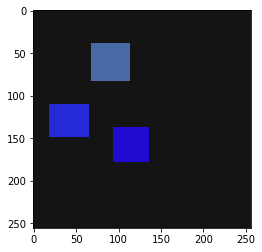

40


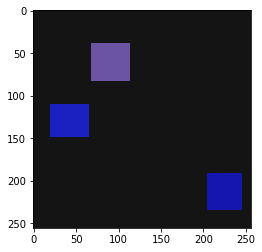

41


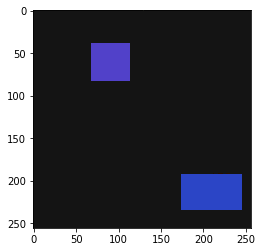

42


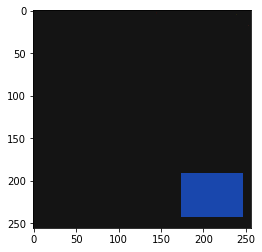

43


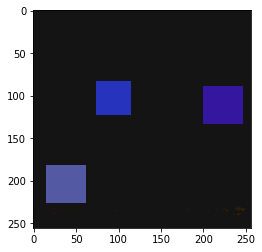

44


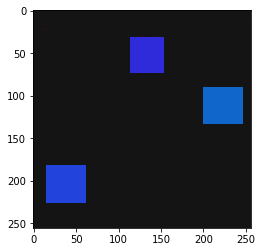

45


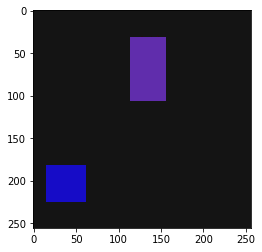

46


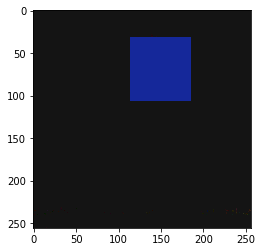

47


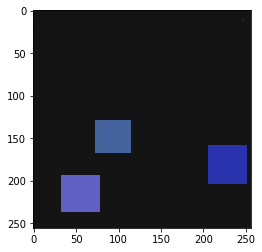

48


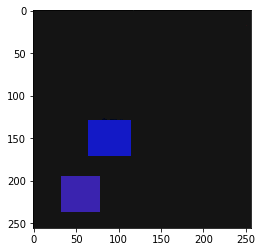

49


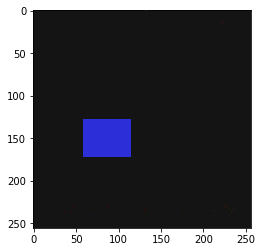

50


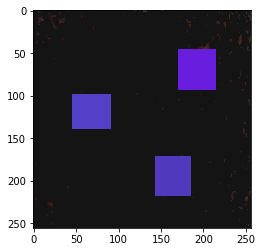

51


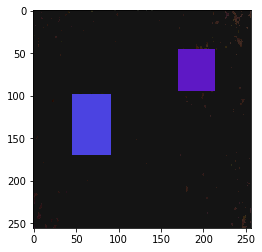

52


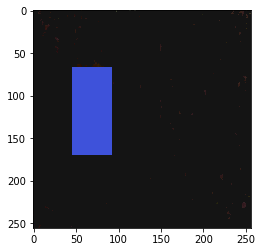

53


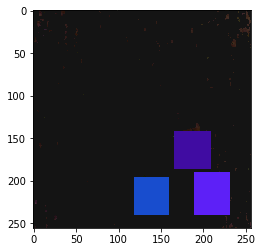

54


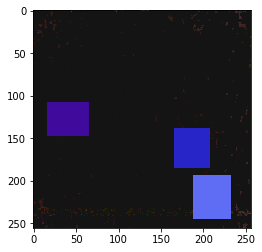

55


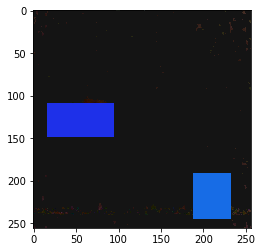

56


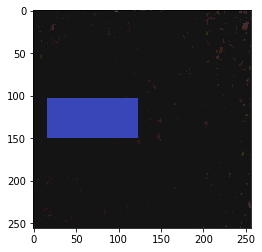

57


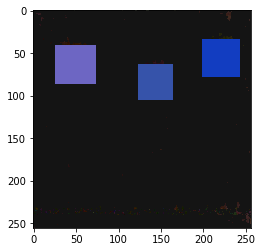

58


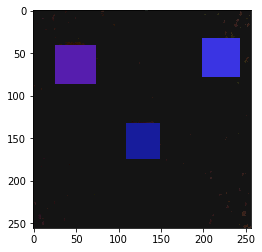

59


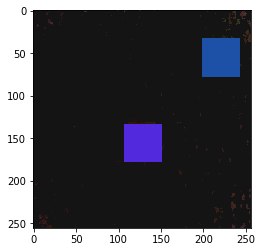

60
8 1
8 1
9 4
9 1


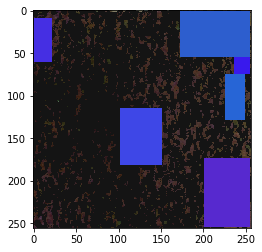

61


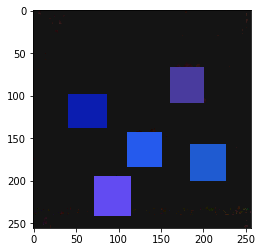

62


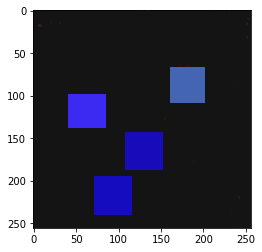

63


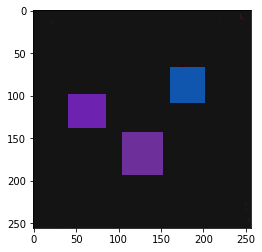

64


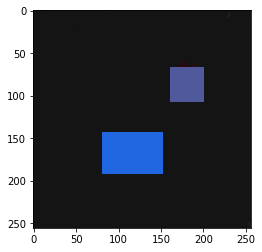

65


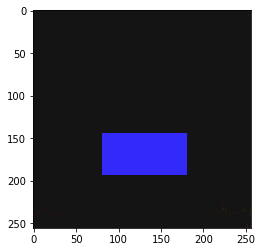

66


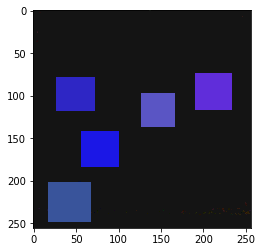

67


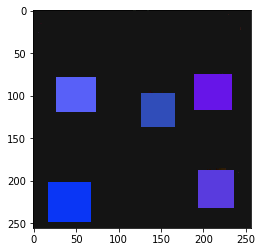

68


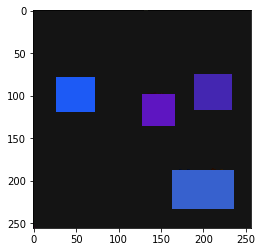

69


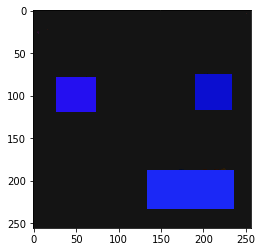

70


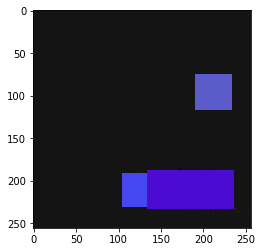

71


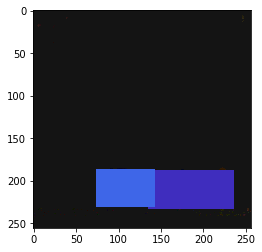

72


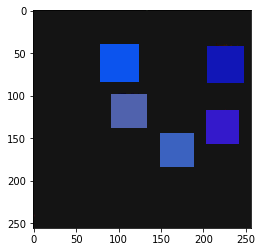

73


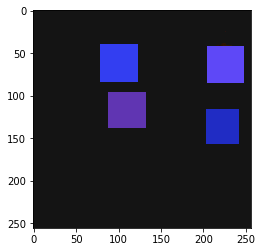

74


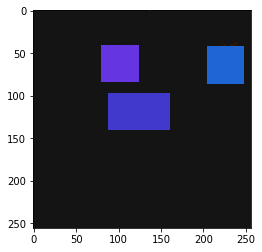

75


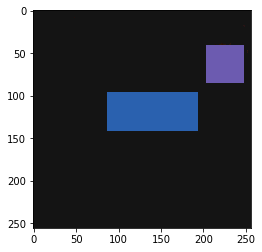

76


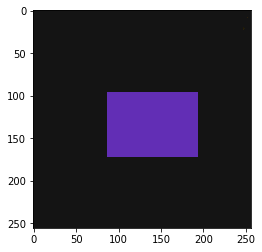

77


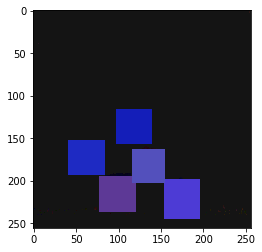

78


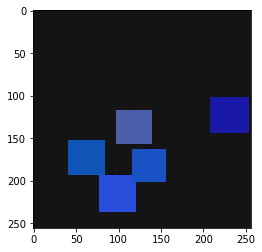

79


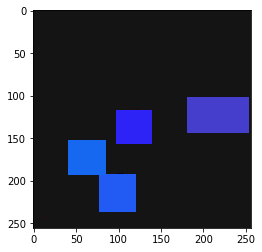

80


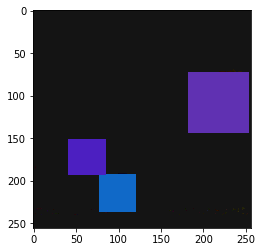

81


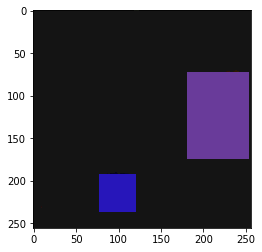

82


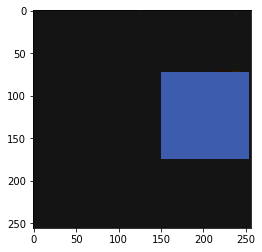

83


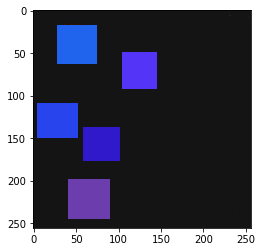

84


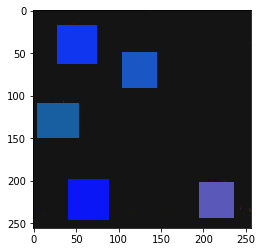

85


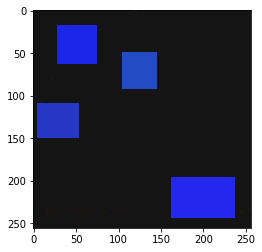

86


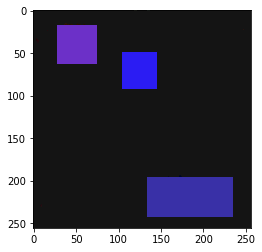

87


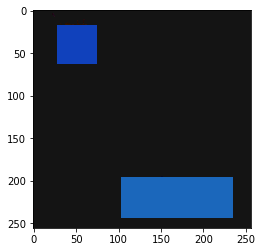

88


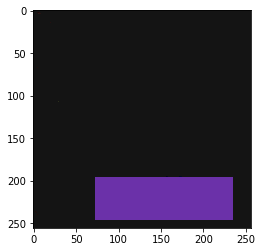

89


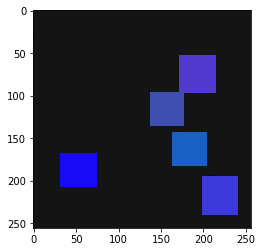

90


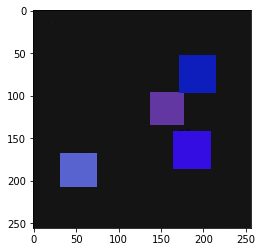

91


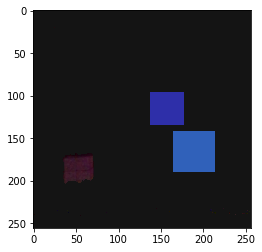

92


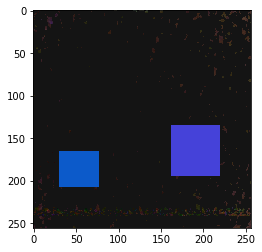

93
7 4


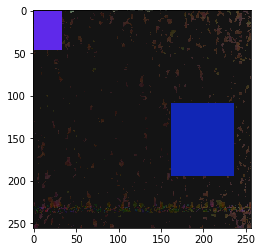

94


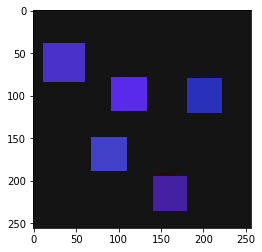

95


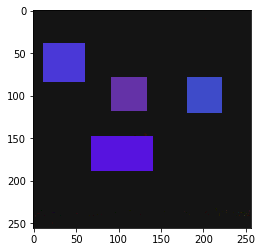

96


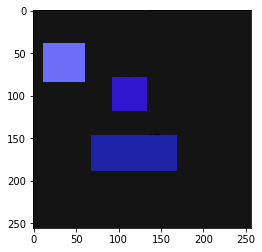

97


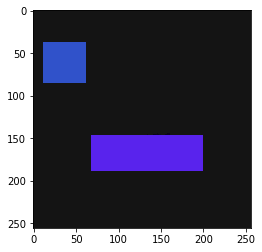

98


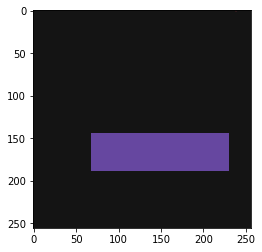

99


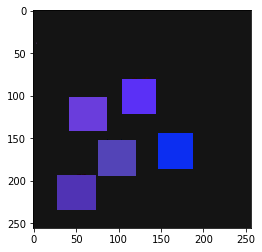

100


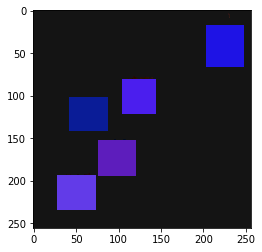

101


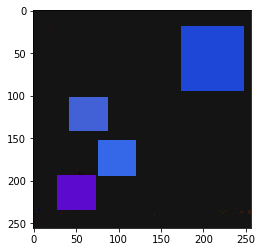

102


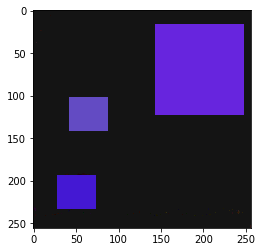

103
6 7


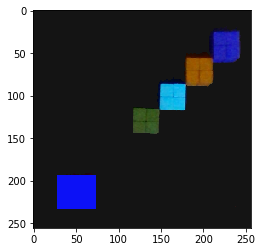

104
3 5


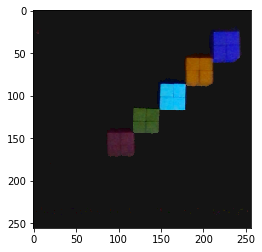

105


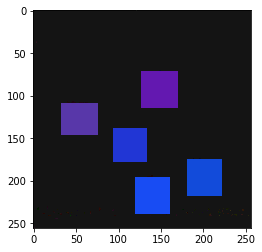

106


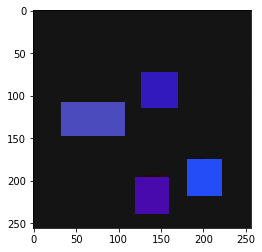

107


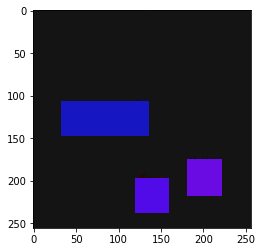

108


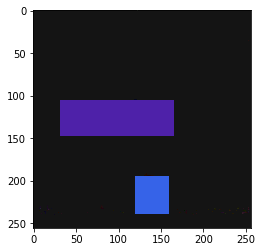

109


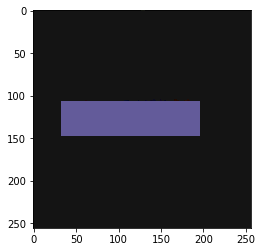

110


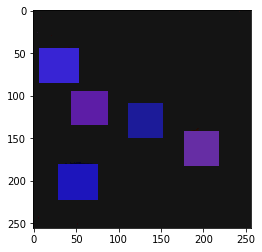

111


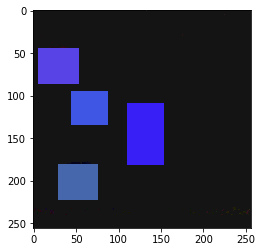

112


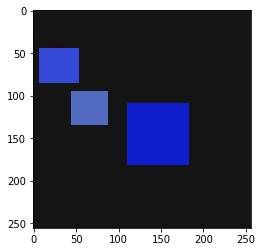

113


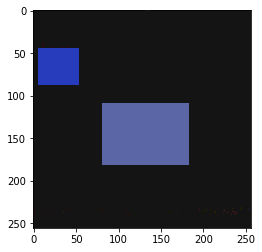

114


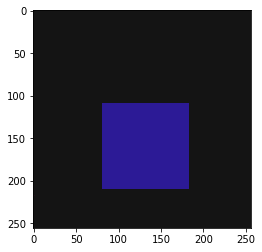

115


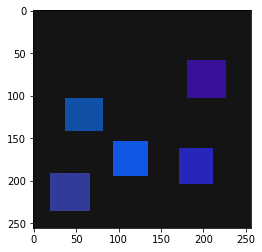

116


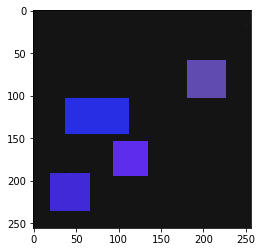

117


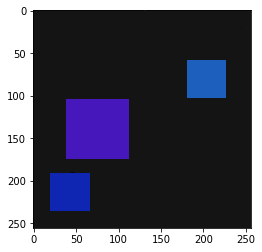

118


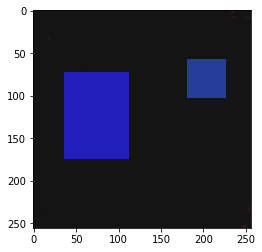

119


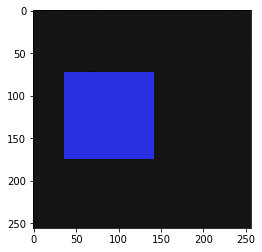

120


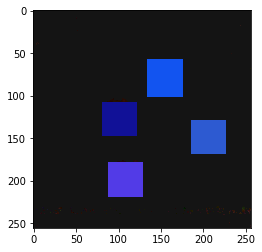

121


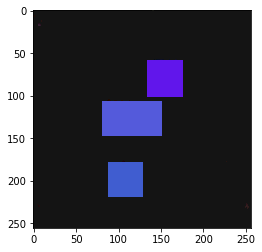

122


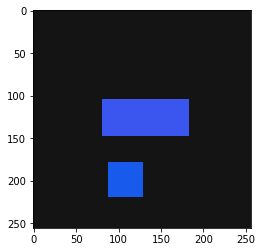

123


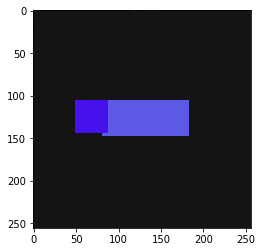

124


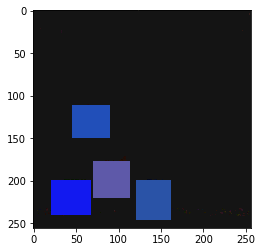

125


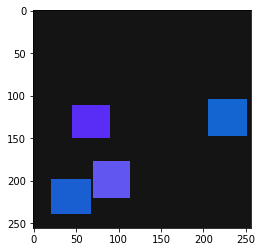

126


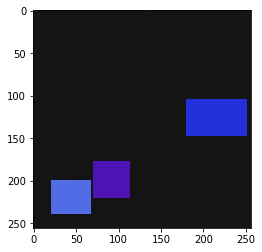

127


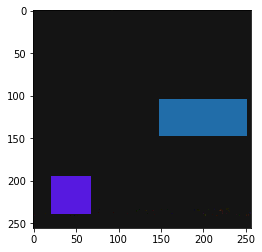

128


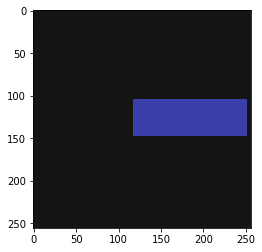

129


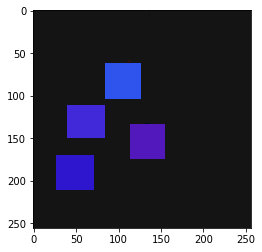

130


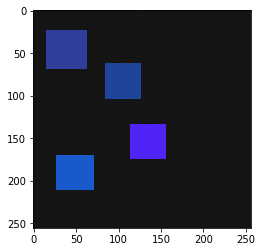

131


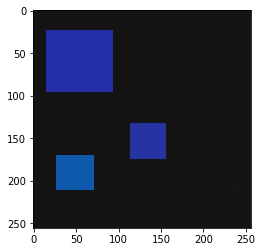

132


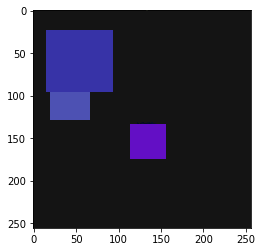

133


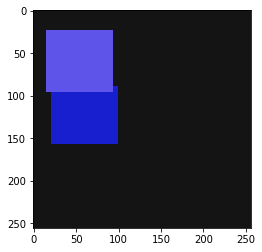

134


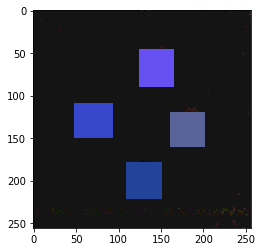

135


KeyboardInterrupt: 

In [35]:
#s_img = img
#s_hulls,s_objs = extract_objects(s_img)
# fig = plt.figure()
# s_ax = fig.add_subplot(111)
# plt.imshow(s_img)
# for s_ob in s_objs :
#     randcolor = (np.random.randint(0,100,size=3) + np.array([10,10,150]))/255.0
#     rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
#                              linewidth=0.00,edgecolor=randcolor,facecolor=randcolor)
#     s_ax.add_patch(rect)


# plt.show()

pp_path = '/home/obin/t2b_dataset/rgbd/image'
data_list = np.sort([pp_path+'/'+x for x in os.listdir(os.path.join(pp_path,''))])
for i in range(25,len(data_list)):
    print(i)
    img = cv2.imread(data_list[i])
    #img = joblib.load(data_list[i])

    depth_image = img

    
    #print(depth_image)
    s_hulls,s_objs, contours = extract_objects(depth_image)

#     for c in contours :
#         print(np.array(c).shape)
    #image = cv2.drawContours(depth_image, s_hulls, -1, 255, 3)
    fig = plt.figure()
    s_ax = fig.add_subplot(111)
    plt.imshow(img)
    for s_ob in s_objs :
        randcolor = (np.random.randint(0,100,size=3) + np.array([10,10,150]))/255.0
        rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
                                 linewidth=0.00,edgecolor=randcolor,facecolor=randcolor)
        s_ax.add_patch(rect)

    
    #cv2.imshow('contoured_image',image)
    #key = cv2.waitKey()
    #print(key)
    plt.show()
    #if key == 113 : break
#cv2.destroyAllWindows()
#print('picture {0}'.format(i))